Setup

In [ ]:
import os
import sys
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt

In [2]:
def dataset_path(path):
  cwd = os.getcwd()
  return os.path.join(cwd, '../../datasets', path)

In [3]:
def show_cv2_image(image, title='image'):
  plt.figure()
  plt.title(title)
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

Get Images

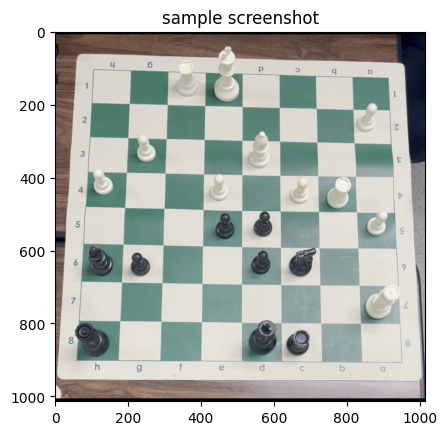

In [24]:
show_cv2_image(cv2.imread(dataset_path('sample_chess.png')), "sample screenshot")

OCR

In [25]:
def ocr_image(input_image, verbose=False):
    """Detects text in the file."""
    from google.cloud import vision

    client = vision.ImageAnnotatorClient()
    
    content = cv2.imencode('.jpg', input_image)[1].tobytes()

    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    
    if verbose:
        print("Texts:")

        for text in texts:
            print(f'\n"{text.description}"')

            vertices = [
                f"({vertex.x},{vertex.y})" for vertex in text.bounding_poly.vertices
            ]

            print("bounds: {}".format(",".join(vertices)))

    if response.error.message:
        raise Exception(
            "{}\nFor more info on error messages, check: "
            "https://cloud.google.com/apis/design/errors".format(response.error.message)
        )
    
    return texts

In [18]:
ocr_image(cv2.imread(dataset_path('crop_scaled.png')))

/var/folders/zs/v7v__8pn45dc699tr5rpqxkw0000gn/T/ipykernel_75906/2477839434.py:7: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  content = cv2.imencode('.jpg', input_image)[1].tostring()


[locale: "und"
description: "8\nh"
bounding_poly {
  vertices {
    x: 232
    y: 310
  }
  vertices {
    x: 716
    y: 310
  }
  vertices {
    x: 716
    y: 806
  }
  vertices {
    x: 232
    y: 806
  }
}
, description: "8"
bounding_poly {
  vertices {
    x: 233
    y: 310
  }
  vertices {
    x: 315
    y: 311
  }
  vertices {
    x: 314
    y: 403
  }
  vertices {
    x: 232
    y: 402
  }
}
, description: "h"
bounding_poly {
  vertices {
    x: 628
    y: 703
  }
  vertices {
    x: 716
    y: 704
  }
  vertices {
    x: 715
    y: 806
  }
  vertices {
    x: 627
    y: 805
  }
}
]

In [25]:
ocr_image(cv2.imread(dataset_path('crop_scaled.png')))

{'level': [1, 2, 3, 4, 5, 4, 5],
 'page_num': [1, 1, 1, 1, 1, 1, 1],
 'block_num': [0, 1, 1, 1, 1, 1, 1],
 'par_num': [0, 0, 1, 1, 1, 1, 1],
 'line_num': [0, 0, 0, 1, 1, 2, 2],
 'word_num': [0, 0, 0, 0, 1, 0, 1],
 'left': [0, 236, 236, 236, 236, 632, 632],
 'top': [0, 305, 305, 305, 305, 695, 695],
 'width': [1016, 473, 473, 77, 77, 77, 77],
 'height': [1014, 506, 506, 110, 110, 116, 116],
 'conf': [-1, -1, -1, -1, 67, -1, 82],
 'text': ['', '', '', '', '8', '', 'h']}

In [9]:
def detection_to_dict(detection):
    return {
        'description': detection.description,
        'vertices': [
            (vertex.x, vertex.y) for vertex in detection.bounding_poly.vertices
        ]
    }

In [ ]:
def draw_box(image, a, b, c, d):
  cv2.polylines(image, [np.array([a, b, c, d], np.int32)], True, (0, 255, 0), 2)

In [10]:
def show_image_with_ocr(image, title='ocr result'):
  result = ocr_image(image)
  
  if len(image.shape) == 2:
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

  for text in result:
    text_dict = detection_to_dict(text)
    vertices = text_dict['vertices']
    draw_box(image, vertices[0], vertices[1], vertices[2], vertices[3])

  show_cv2_image(image, title)
  
def show_image_with_ocr_labelled(image, title='ocr result'):
  result = ocr_image(image)
  
  if len(image.shape) == 2:
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
  
  for text in result:
    text_dict = detection_to_dict(text)
    vertices = text_dict['vertices']
    draw_box(image, vertices[0], vertices[1], vertices[2], vertices[3])
    cv2.putText(image, text_dict['description'], vertices[0], cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
  
  show_cv2_image(image, title)

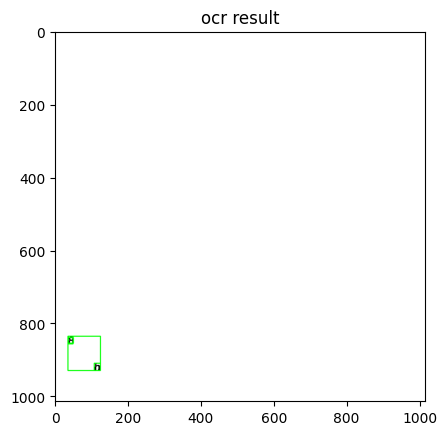

In [21]:
show_image_with_ocr(cv2.imread(dataset_path('only_numbers.png')))

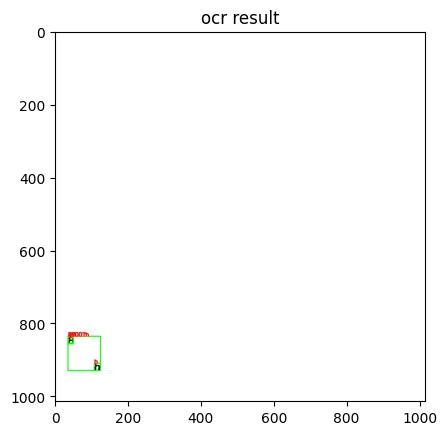

In [22]:
show_image_with_ocr_labelled(cv2.imread(dataset_path('only_numbers.png')))

OCR With Our Images

In [26]:
# Function to compute the intersection of two lines
def compute_intersection(line1, line2):
    rho1, theta1 = line1
    rho2, theta2 = line2

    # Calculate the intersection of two lines
    A = np.array([[np.cos(theta1), np.sin(theta1)], [np.cos(theta2), np.sin(theta2)]])
    b = np.array([rho1, rho2])

    # Solve the linear system to find the intersection point
    intersection = np.linalg.solve(A, b)
    return int(intersection[0]), int(intersection[1])

In [28]:
def draw_white_board_boundaries(image):
    # Convert the image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the range of green color in HSV
    lower_green = np.array([40, 25, 40])  # Lower bound of green in HSV
    upper_green = np.array([100, 200, 200])  # Upper bound of green in HSV

    # Threshold the image to get only the green color
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a black canvas to draw contours
    contour_image = np.zeros_like(mask)

    # Draw the contours on the black canvas (255 for white contours)
    cv2.drawContours(contour_image, contours, -1, (255), 1)

    # Apply the Canny edge detector on the contour image
    edges = cv2.Canny(contour_image, 50, 150, apertureSize=3)

    # Apply Hough Line Transform to find lines in the edge-detected image
    lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=100)

    # Separate the lines into vertical and horizontal based on their angle (theta)
    vertical_lines = []
    horizontal_lines = []

    # Find vertical and horizontal lines
    if lines is not None:
        for rho, theta in lines[:, 0]:
            # Identify vertical lines (theta near 0 or 180 degrees)
            if np.abs(theta) < np.pi / 180 * 10 or np.abs(theta - np.pi) < np.pi / 180 * 10:
                vertical_lines.append((rho, theta))
            # Identify horizontal lines (theta near 90 degrees)
            elif np.abs(theta - np.pi / 2) < np.pi / 180 * 10:
                horizontal_lines.append((rho, theta))

    # Create an empty list to store intersection points
    intersection_points = []

    # Find intersection points between vertical and horizontal lines
    for v_line in vertical_lines:
        for h_line in horizontal_lines:
            intersection = compute_intersection(v_line, h_line)
            intersection_points.append(intersection)

    # Create an empty image to draw the intersection points
    intersection_image = np.zeros_like(image)

    # Draw the intersection points on the image (red points)
    for point in intersection_points:
        cv2.circle(intersection_image, point, 10, (0, 0, 255), -1)  # Red circle at intersection points

    # Convert the intersection image to grayscale
    grayscale_image = cv2.cvtColor(intersection_image, cv2.COLOR_BGR2GRAY)

    # Find contours of the red intersection points (non-zero pixels)
    contours, _ = cv2.findContours(grayscale_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty black image to draw the center points
    center_image = np.copy(image)

    # List to store the center points' coordinates
    center_points = []

    # Iterate over each contour and find the centroid (center point)
    for contour in contours:
        # Calculate the moments of the contour
        moments = cv2.moments(contour)
        
        # Calculate the centroid (center) of the contour
        if moments['m00'] != 0:
            cx = int(moments['m10'] / moments['m00'])
            cy = int(moments['m01'] / moments['m00'])
            
            # Draw the center point (blue) on the original image
            cv2.circle(center_image, (cx, cy), 5, (255, 0, 0), -1)  # Blue circle at center
            
            # Store the center coordinates in the list
            center_points.append((cx, cy))
    center_points = sorted(center_points, key=lambda x: sum(x))

    # Step 1: Find the convex hull of the center points
    center_points_np = np.array(center_points, dtype=np.int32)  # Convert to NumPy array
    hull = cv2.convexHull(center_points_np)  # Compute convex hull

    # Step 2: Create a mask for the filled polygon
    mask = np.ones_like(image, dtype=np.uint8) * 255  # Create a white mask with the same dimensions as the image
    cv2.fillPoly(mask, [hull], (0, 0, 0))  # Draw the filled polygon in black on the mask
    
    image[mask == 0] = 255
    result_image = image

    return result_image


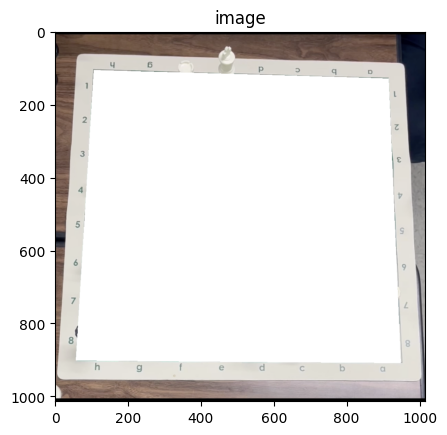

In [29]:
show_cv2_image(draw_white_board_boundaries(cv2.imread(dataset_path('sample_chess.png'))))

In [30]:
def process_image(image):
  processed_image = draw_white_board_boundaries(image)
  
  result = processed_image
  return result

detect chessboard orientation

In [33]:
# ORIENTATIONS
#   'UPRIGHT' => 8 is top-left, h is bottom-right
#   'ROTATED_RIGHT' => # 8 is top-right, h is bottom-left
#   'UPSIDE_DOWN' => 8 is bottom-right, h is top-left
#   'ROTATED_LEFT' => 8 is bottom-left, h is top-right
# }

def bounding_box(left, top, width, height):
  return [(left, top), (left + width, top), (left + width, top + height), (left, top + height)]

def draw_bounding_box(image, box, color=(0, 255, 0)):
  cv2.polylines(image, [np.array(box)], isClosed=True, color=color, thickness=2)
  return image

def get_board_orientation(bound_8, bound_h):
  # compute the center of the two bounding boxes
  center_8 = np.mean(np.array(bound_8), axis=0)
  center_h = np.mean(np.array(bound_h), axis=0)
  
  # check the relative position of the two centers
  if center_8[0] < center_h[0] and center_8[1] < center_h[1]:
    return 'UPRIGHT'
  elif center_8[0] > center_h[0] and center_8[1] > center_h[1]:
    return 'UPSIDE_DOWN'
  elif center_8[0] < center_h[0] and center_8[1] > center_h[1]:
    return 'ROTATED_RIGHT'
  elif center_8[0] > center_h[0] and center_8[1] < center_h[1]:
    return 'ROTATED_LEFT'
  

def detect_chessboard_orientation(image):
  data = ocr_image(image)
  
  bounds_8 = [] # sample: [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]
  bounds_h = [] # sample: [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]
  
  for detection in data:
    data_dict = detection_to_dict(detection)
    if data_dict['description'] == '8':
      # store the bounding box of the 8
      bounds_8.append(data_dict['vertices'])
    elif data_dict['description'] == 'h':
      bounds_h.append(data_dict['vertices'])
  
  # find the closest pair of 8 and h
  closest = None
  
  for bound_8 in bounds_8:
    for bound_h in bounds_h:
      distance = np.linalg.norm(np.array(bound_8) - np.array(bound_h))
      
      if closest is None or distance < closest[0]:
        closest = (distance, bound_8, bound_h)
        
  print(f'Closest pair: {closest}')
  
  if closest is None:
    return False, closest
  
  # compute the center of the two bounding boxes
  center_8 = np.mean(np.array(closest[1]), axis=0)
  center_h = np.mean(np.array(closest[2]), axis=0)
  
  # draw the line between the two points
  cv2.line(image, tuple(center_8.astype(int)), tuple(center_h.astype(int)), (255, 0, 0), 2)
  
  # draw the bounding boxes
  image = draw_bounding_box(image, bound_8, (0, 255, 0))
  image = draw_bounding_box(image, bound_h, (0, 0, 255))
  
  show_cv2_image(image, "detected image")
    
  return get_board_orientation(closest[1], closest[2]), closest

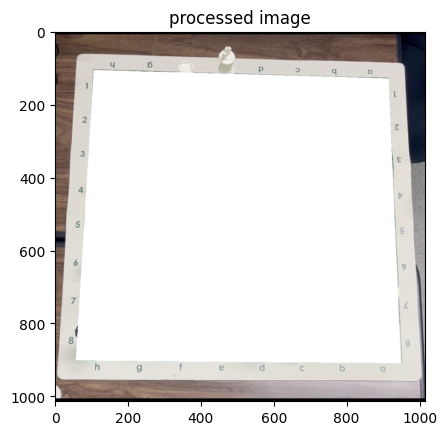

In [34]:
show_cv2_image(process_image(cv2.imread(dataset_path('sample_chess.png'))), "processed image")

Closest pair: (np.float64(206.53329029480938), [(37, 838), (50, 839), (49, 856), (36, 855)], [(108, 910), (125, 910), (125, 929), (108, 929)])


('UPRIGHT',
 (np.float64(206.53329029480938),
  [(37, 838), (50, 839), (49, 856), (36, 855)],
  [(108, 910), (125, 910), (125, 929), (108, 929)]))

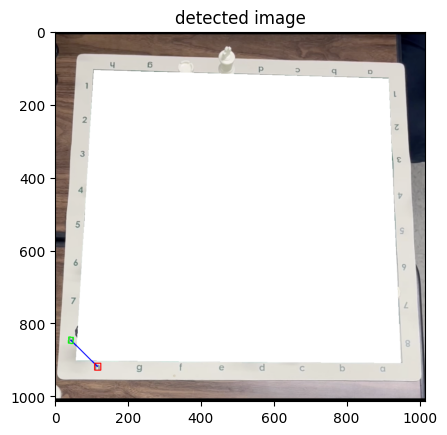

In [35]:
detect_chessboard_orientation(process_image(cv2.imread(dataset_path('sample_chess.png'))))

In [36]:
def rotate_test(image):
  images = [image]
  # rotate
  image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
  images.append(image)

  # flip
  image = cv2.flip(image, 1)
  images.append(image)

  # rotate
  image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

  images.append(image)
  
  has_detected = False
  # detect orientation
  for i, image in enumerate(images):
    result = detect_chessboard_orientation(process_image(image))
    if result[0]:
      has_detected = True
      
  if not has_detected:
    show_image_with_ocr_labelled(images[0])

In [39]:
image_paths = glob.glob(dataset_path('chess/*'))

Closest pair: (np.float64(203.67621363330574), [(35, 843), (51, 843), (51, 860), (35, 860)], [(107, 914), (122, 914), (122, 934), (107, 934)])
Closest pair: (np.float64(199.42918542680758), [(170, 35), (170, 51), (152, 51), (152, 35)], [(98, 105), (98, 122), (83, 122), (83, 105)])
Closest pair: None
Closest pair: None


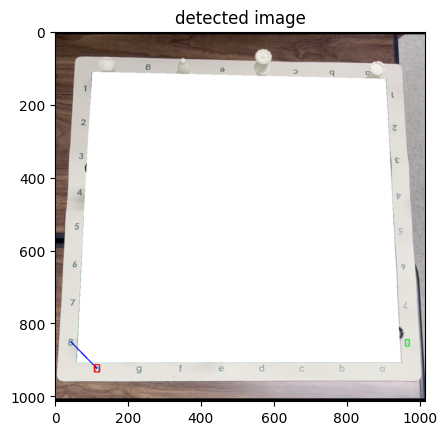

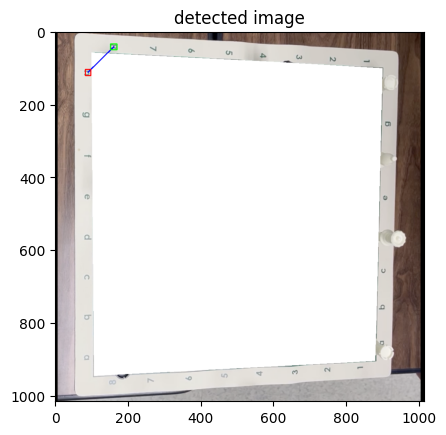

In [40]:
rotate_test(cv2.imread(image_paths[0]))

The final test

Closest pair: (np.float64(203.67621363330574), [(35, 843), (51, 843), (51, 860), (35, 860)], [(107, 914), (122, 914), (122, 934), (107, 934)])
Closest pair: (np.float64(199.42918542680758), [(170, 35), (170, 51), (152, 51), (152, 35)], [(98, 105), (98, 122), (83, 122), (83, 105)])
Closest pair: None
Closest pair: None
Processed /Users/betich/code/work/RoboticsAI/chess-detection/src/chess_board/../../datasets/chess/Screenshot 2567-12-07 at 21.29.08.png
Closest pair: (np.float64(206.53329029480938), [(37, 838), (50, 839), (49, 856), (36, 855)], [(108, 910), (125, 910), (125, 929), (108, 929)])
Closest pair: (np.float64(1524.0170602719643), [(175, 37), (174, 50), (157, 49), (158, 36)], [(912, 165), (912, 151), (926, 151), (926, 165)])
Closest pair: None
Closest pair: None
Processed /Users/betich/code/work/RoboticsAI/chess-detection/src/chess_board/../../datasets/chess/Screenshot 2567-12-07 at 21.32.06.png
Closest pair: None
Closest pair: (np.float64(205.10485123467947), [(37, 834), (50, 8

/var/folders/zs/v7v__8pn45dc699tr5rpqxkw0000gn/T/ipykernel_75906/379158312.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Closest pair: (np.float64(204.36731636932555), [(171, 35), (171, 49), (154, 49), (154, 35)], [(99, 106), (99, 122), (81, 122), (81, 106)])
Closest pair: None
Closest pair: None
Processed /Users/betich/code/work/RoboticsAI/chess-detection/src/chess_board/../../datasets/chess/Screenshot 2567-12-07 at 21.31.24.png
Closest pair: None
Closest pair: (np.float64(203.01724064719232), [(36, 855), (37, 834), (50, 835), (49, 856)], [(107, 905), (123, 905), (123, 924), (107, 924)])
Closest pair: None
Closest pair: None
Processed /Users/betich/code/work/RoboticsAI/chess-detection/src/chess_board/../../datasets/chess/Screenshot 2567-12-07 at 21.28.05.png
Closest pair: (np.float64(206.64946164943183), [(36, 842), (50, 843), (49, 859), (35, 858)], [(105, 914), (123, 914), (123, 936), (105, 936)])
Closest pair: (np.float64(1709.0061439327828), [(150, 973), (150, 960), (165, 960), (165, 973)], [(99, 107), (99, 123), (80, 123), (80, 107)])
Closest pair: None
Closest pair: None
Processed /Users/betich/cod

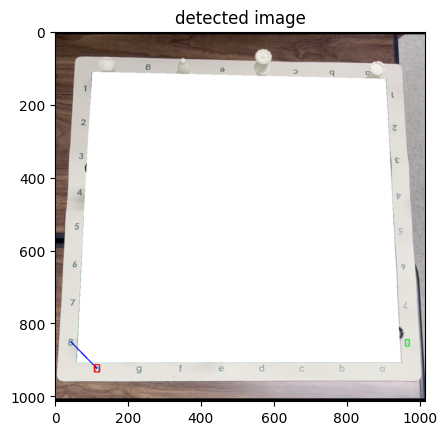

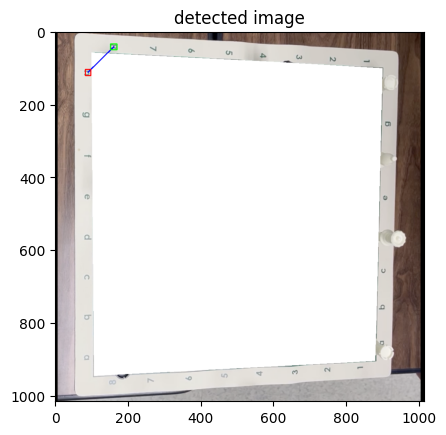

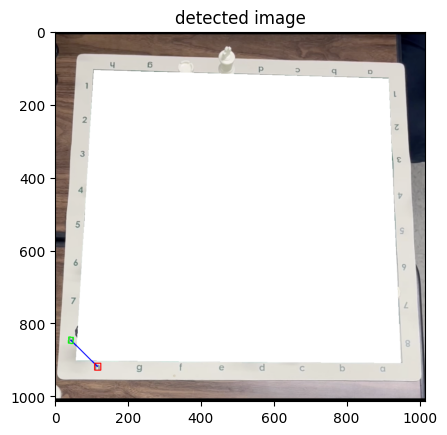

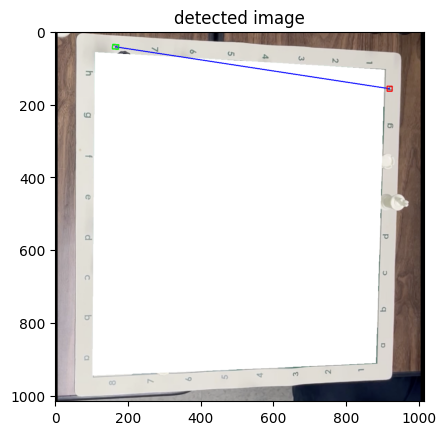

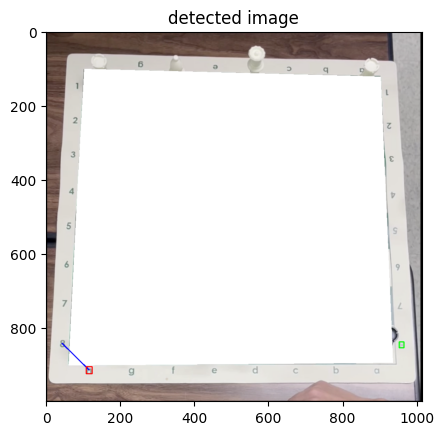

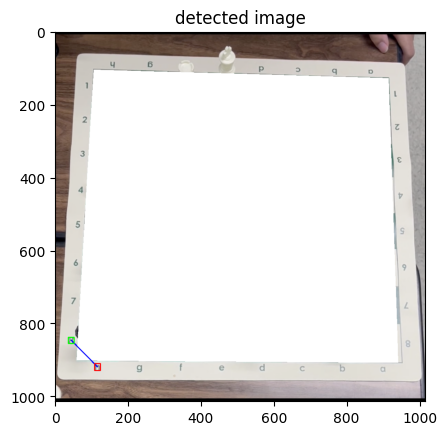

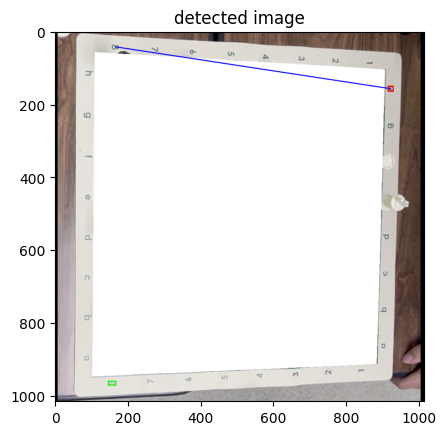

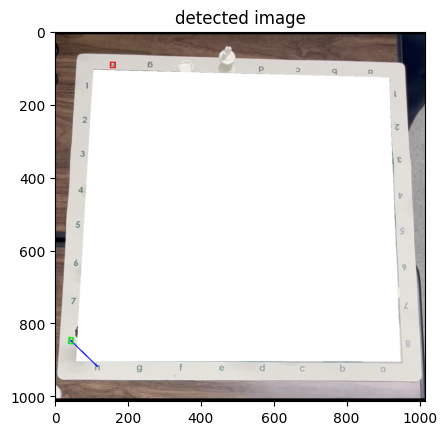

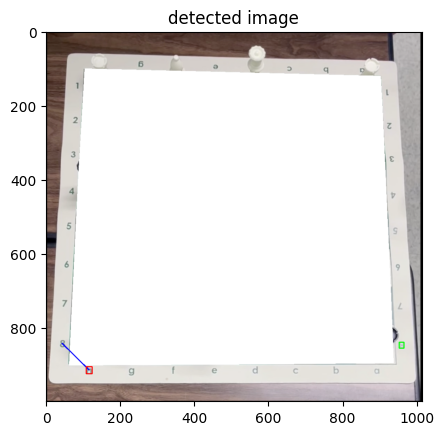

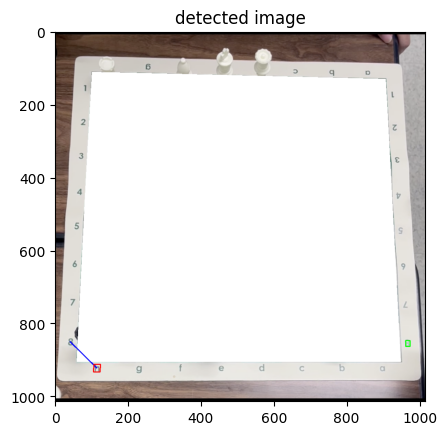

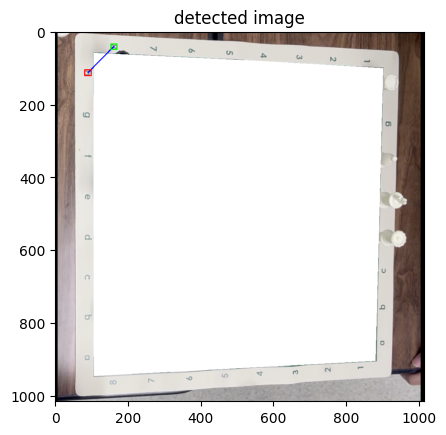

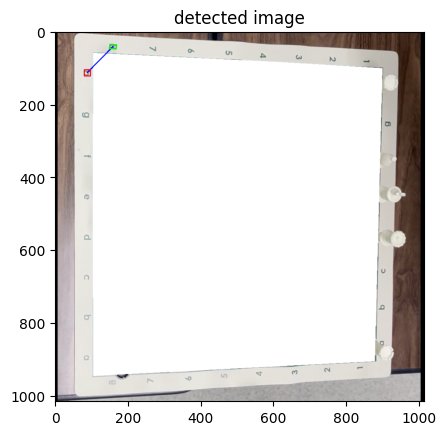

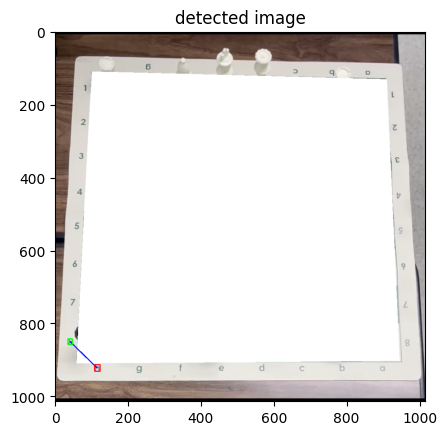

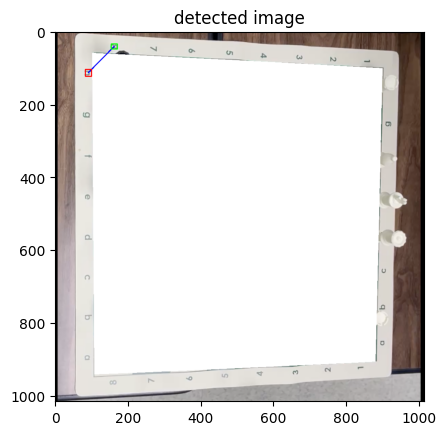

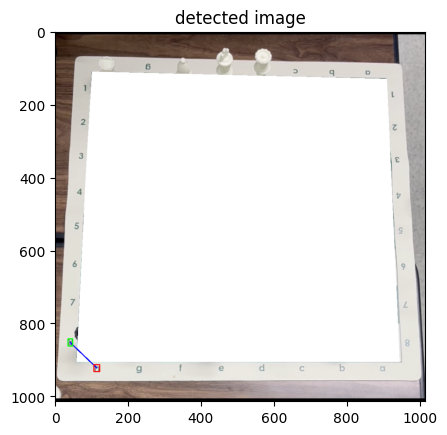

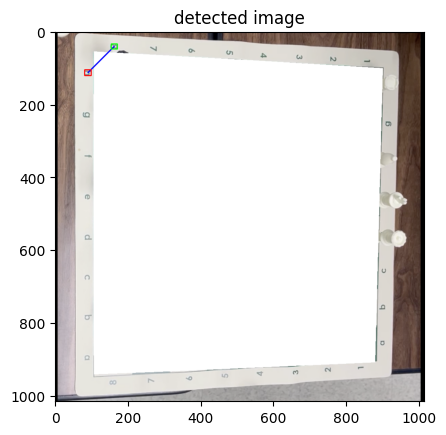

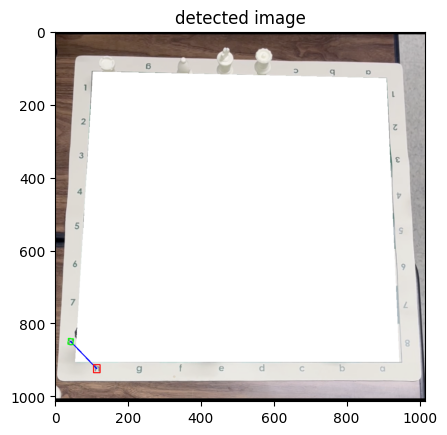

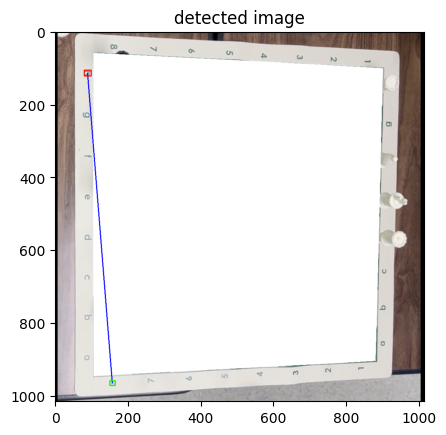

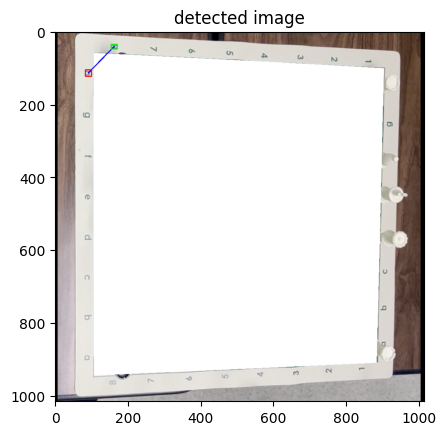

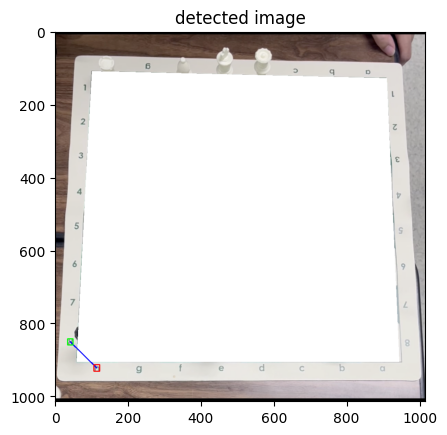

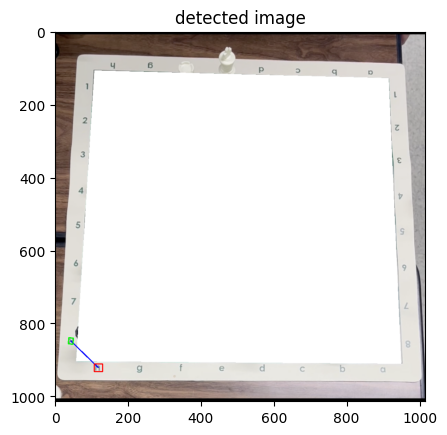

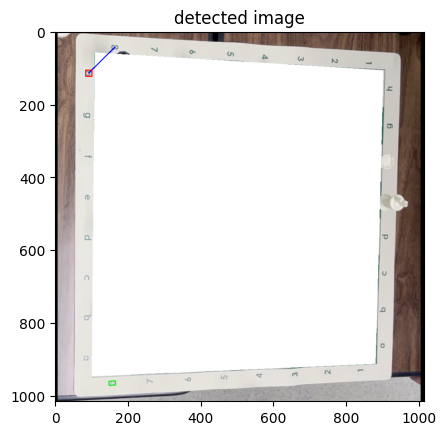

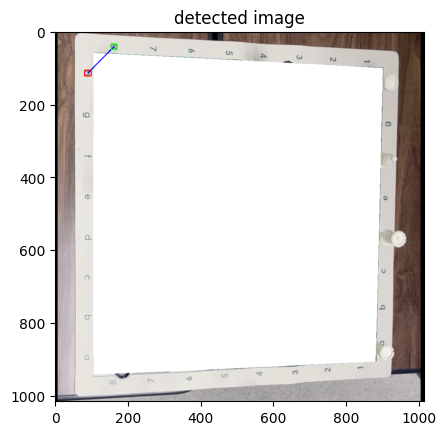

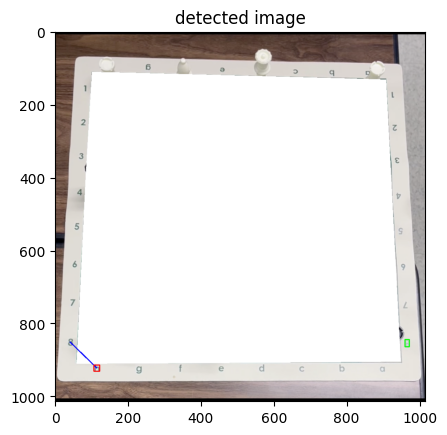

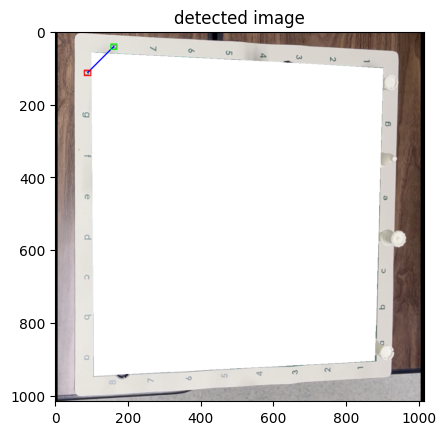

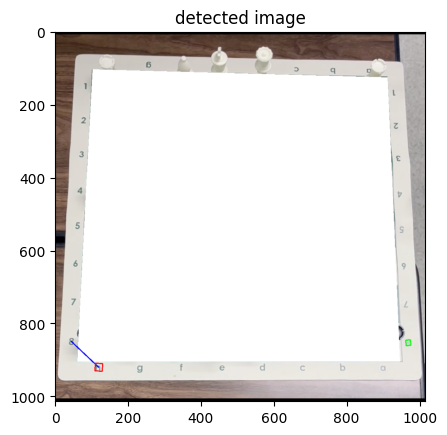

In [43]:
for image_path in image_paths:
  image = cv2.imread(image_path)
  rotate_test(image)
  print(f"Processed {image_path}")